# How to Run TARDIS with a Custom Packet Source


By default, TARDIS generates energy packets using its interface `BasePacketSource` class, which has a derived class `BlackBodySimpleSource`, which models the photosphere of the supernova as a perfect blackbody (see [Energy Packet Initialization](../../physics/montecarlo/initialization.ipynb)). However, users may create their own packet source, as will be shown in this notebook. In order to do this, a user must create a class (that inherits from `BasePacketSource`) and implement the following abstract functions:

- create_packet_radii (returns array of packet radii)
- create_packet_nus (returns array of packet frequencies)
- create_packet_mus (returns array of packet directions)
- create_packet_energies (returns array of packet energies. See [Energy Packet Initialization](../../physics/montecarlo/initialization.ipynb) for more information)
- create_packets (wrapper which calls the above 4 functions, and is the function used by external code)
- set_state_from_model (set the state of the source from a model object)

[Note: In this notebook, we have extended the `BlackBodySimpleSource` class because it already implements some of the above functions]

To use your packet source in a run of TARDIS, you must pass an instance of your class into the `run_tardis` function under the `packet_source` keyword argument.

.. note:: In both the `BlackBodySimpleSource` class and in the example here, all packets are generated at the same radius. This need not be true in general (though one call of the `create_packets` method will pick the same radius from the packet source state).

We show an example of how a custom packet source is used:


In [1]:
# Import necessary packages
import numpy as np
from tardis import constants as const
from astropy import units as u
from tardis.transport.montecarlo.packet_source import BlackBodySimpleSource
from tardis.transport.montecarlo.packet_collections import (
    PacketCollection,
)
from tardis import run_tardis
import matplotlib.pyplot as plt
from tardis.io.atom_data import download_atom_data

Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

In [2]:
# Download the atomic data used for a run of TARDIS
download_atom_data("kurucz_cd23_chianti_H_He")

Atomic Data kurucz_cd23_chianti_H_He already exists in /home/runner/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5. Will not download - override with force_download=True.


In [3]:
# Create a packet source class that contains a create_packets method
class TruncBlackbodySource(BlackBodySimpleSource):
    """
    Custom inner boundary source class to replace the Blackbody source
    with a truncated Blackbody source.

    Parameters
    ----------
    truncation_wavelength : float
        truncation wavelength in Angstrom.
        Only wavelengths higher than the truncation wavelength
        will be sampled.
    radius : float64
        Initial packet radius
    temperature : float
        Absolute Temperature.
    base_seed : int
        Base Seed for random number generator
    """

    def __init__(self, truncation_wavelength=None, **kwargs):
        self.truncation_wavelength = truncation_wavelength
        super().__init__(**kwargs)

    def create_packets(self, no_of_packets, drawing_sample_size=None, seed_offset=0, *args, **kwargs):
        """
        Packet source that generates a truncated Blackbody source.

        Parameters
        ----------
        no_of_packets : int
            number of packets to be created

        Returns
        -------
        array
            Packet radii
        array
            Packet frequencies
        array
            Packet directions
        array
            Packet energies
        """

        self._reseed(self.base_seed + seed_offset)
        packet_seeds = self.rng.choice(
            self.MAX_SEED_VAL, no_of_packets, replace=True
        )

        # Makes uniform array of packet radii from blackbody source
        radii = self.create_packet_radii(no_of_packets, *args, **kwargs)

        # Use mus and energies from normal blackbody source.
        mus = self.create_packet_mus(no_of_packets, *args, **kwargs)
        energies = self.create_packet_energies(no_of_packets, *args, **kwargs)

        # If not specified, draw 2 times as many packets and reject any beyond no_of_packets.
        if drawing_sample_size is None:
            drawing_sample_size = 2 * no_of_packets

        # Blackbody will be truncated below truncation_wavelength / above truncation_frequency.
        truncation_frequency = (
            u.Quantity(self.truncation_wavelength, u.Angstrom)
            .to(u.Hz, equivalencies=u.spectral())
        )

        # Draw nus from blackbody distribution and reject based on truncation_frequency.
        # If more nus.shape[0] > no_of_packets use only the first no_of_packets.
        nus = self.create_packet_nus(drawing_sample_size, *args, **kwargs)
        nus = nus[nus < truncation_frequency][:no_of_packets]

        # Only required if the truncation wavelength is too big compared to the maximum
        # of the blackbody distribution. Keep sampling until nus.shape[0] > no_of_packets.
        while nus.shape[0] < no_of_packets:
            additional_nus = self.create_packet_nus(drawing_sample_size, *args, **kwargs)
            mask = additional_nus < truncation_frequency
            additional_nus = additional_nus[mask][:no_of_packets]
            nus = np.hstack([nus, additional_nus])[:no_of_packets]

        radiation_field_luminosity = (
            self.calculate_radfield_luminosity().to(u.erg / u.s).value
        )

        return PacketCollection(radii, nus, mus, energies, packet_seeds, radiation_field_luminosity)

In [4]:
# Call an instance of the packet source class
packet_source = TruncBlackbodySource(
    truncation_wavelength=2000, base_seed=53253
)

We now run TARDIS both with and without our custom packet source, and we compare the results:


In [5]:
mdl = run_tardis("tardis_example.yml", packet_source=packet_source)
mdl_norm = run_tardis("tardis_example.yml")

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

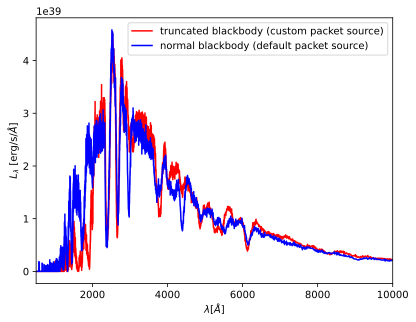

In [6]:
%matplotlib inline
plt.plot(mdl.spectrum_solver.spectrum_virtual_packets.wavelength,
         mdl.spectrum_solver.spectrum_virtual_packets.luminosity_density_lambda,
         color='red', label='truncated blackbody (custom packet source)')
plt.plot(mdl_norm.spectrum_solver.spectrum_virtual_packets.wavelength,
         mdl_norm.spectrum_solver.spectrum_virtual_packets.luminosity_density_lambda,
         color='blue', label='normal blackbody (default packet source)')
plt.xlabel('$\lambda [\AA]$')
plt.ylabel('$L_\lambda$ [erg/s/$\AA$]')
plt.xlim(500, 10000)
plt.legend()